In [16]:
import pandas as pd
import numpy as np
import os
import scipy
import itertools
#os.environ['XGBOOST_BUILD_DOC'] = 'C:\\Users\\sushant\\Anaconda2\\lib\\site-packages\\xgboost;'
import matplotlib.pyplot as plt    
import xgboost as xgb
iv=['np'	, 'os'	 ,'pd'	, 'plt'	 ,'tqdm'	, 'train'	 ,'train_date'	, 'train_date_num'	, 'train_num'	 ]
def memchk(iv):
    import sys,operator
    ipython_vars=iv
    ,'warnings'	, 'xgboost']
    print sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    return sorted([{i:sys.getsizeof(globals().get(i))/1000000.0} for i in ipython_vars])
%matplotlib inline
from sklearn.metrics import confusion_matrix
import warnings
%load_ext autotime
warnings.filterwarnings('ignore')
from tqdm import tqdm
#plt.style.use('classic')

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 27 ms


In [9]:
#rlimit=500

``` * No of Chunks = 12 *
```

#### Total Rows

```
tot_len =0
for i in range(1,13):
    data = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Numeric\\train_'+str(i)+'.gzip',nrows=rlimit,compression='gzip',usecols=[1])
    tot_len +=len(data)
    del data
tot_len
```

In [18]:
import seaborn as sns

train_date_part = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Date\\train_1.gzip',compression='gzip',usecols=[0,1])
print(train_date_part.shape)
print(1.0 * train_date_part.count().sum() / train_date_part.size)
print(train_date_part[:2])
data = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Numeric\\train_'+str(2)+'.gzip',compression='gzip',usecols=[0,1])

(10000, 2)
0.78665
   Id  L0_S0_D1
0   4     82.24
1   6       NaN


In [19]:
data.count().sum(),data.size

(158017, 200000)

In [20]:
train_date_part.count().sum(),train_date_part.size

(15733, 20000)

In [12]:
# Let's check the min and max times for each station
def get_station_times(dates, withId=False):
    times = []
    cols = list(dates.columns)
    if 'Id' in cols:
        cols.remove('Id')
    for feature_name in cols:
        if withId:
            df = dates[['Id', feature_name]].copy()
            df.columns = ['Id', 'time']
        else:
            df = dates[[feature_name]].copy()
            df.columns = ['time']
        df['station'] = feature_name.split('_')[1][1:]
        #print feature_name.split('_')[1][1:]
        #print df
        
        df = df.dropna()
        times.append(df)
        #break
    return pd.concat(times)


In [13]:
station_times = get_station_times(train_date_part, withId=True).sort_values(by=['Id', 'station'])
print(station_times[:5])
print(station_times.shape)
min_station_times = station_times.groupby(['Id', 'station']).min()['time']
max_station_times = station_times.groupby(['Id', 'station']).max()['time']
print(np.mean(1. * (min_station_times == max_station_times)))


KeyError: "['Id'] not in index"

In [101]:
(min_station_times != max_station_times)

pandas.core.series.Series

In [167]:
# Read station times for train and test
date_cols = train_date_part.drop('Id', axis=1).count().reset_index().sort_values(by=0, ascending=False)
date_cols['station'] = date_cols['index'].apply(lambda s: s.split('_')[1])
date_cols = date_cols.drop_duplicates('station', keep='first')['index'].tolist()
print(date_cols) # selected features


['L3_S37_D3949', 'L3_S30_D3541', 'L3_S29_D3428', 'L3_S34_D3877', 'L3_S33_D3870', 'L0_S0_D3', 'L0_S1_D30', 'L0_S8_D145', 'L3_S36_D3919', 'L3_S35_D3910', 'L0_S5_D115', 'L0_S3_D70', 'L0_S6_D120', 'L0_S7_D143', 'L0_S2_D54', 'L0_S4_D106', 'L0_S12_D333', 'L0_S20_D465', 'L0_S13_D355', 'L0_S10_D266', 'L0_S11_D284', 'L0_S9_D192', 'L2_S26_D3084', 'L1_S24_D1828', 'L0_S19_D457', 'L0_S17_D432', 'L0_S14_D380', 'L0_S15_D401', 'L0_S16_D428', 'L2_S27_D3156', 'L0_S18_D447', 'L0_S21_D469', 'L0_S23_D629', 'L0_S22_D608', 'L3_S41_D4021', 'L3_S40_D3981', 'L3_S45_D4129', 'L3_S48_D4203', 'L3_S47_D4155', 'L3_S39_D3974', 'L3_S51_D4255', 'L1_S25_D1887', 'L3_S31_D3848', 'L3_S43_D4097', 'L3_S49_D4208', 'L3_S50_D4254', 'L3_S44_D4122', 'L3_S38_D3953', 'L3_S32_D3852', 'L2_S28_D3234', 'L3_S46_D4135', 'L3_S42_D4057']


In [168]:
train_date = train_date_part#pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Date\\train_1.gzip', nrows=rlimit,compression='gzip', usecols=date_cols)
print(train_date.shape)
train_station_times = get_station_times(train_date, withId=False)
print(train_station_times.shape)
train_time_cnt = train_station_times.groupby('time').count()[['station']].reset_index()
train_time_cnt.columns = ['time', 'cnt']
print(train_time_cnt.shape)


(20000, 1157)
(4097082, 2)
(29739, 2)


In [169]:
train_station_times.head()

,time,station
0,82.24,0
2,1618.70,0
3,1149.20,0
4,602.64,0
5,1331.66,0


In [170]:
train_time_cnt.sort('cnt',ascending=False).head()

,time,cnt
14740,879.78,2414
16108,937.40,1880
12736,757.29,1862
26186,1431.87,1844
16213,940.33,1834


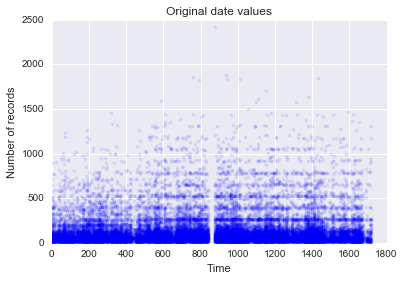

In [171]:

fig = plt.figure()
plt.plot(train_time_cnt['time'].values, train_time_cnt['cnt'].values, 'b.', alpha=0.1, label='train')
plt.title('Original date values')
plt.ylabel('Number of records')
plt.xlabel('Time')
fig.savefig('original_date_values.png', dpi=300)
plt.show()


In [61]:
data = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Date\\train_1.gzip', chunksize=500,compression='gzip')

In [6]:
import time
k=0
dc={0:'r',1:'b',2:'g'}
#ax=plt.axis()
for i in data:
    time.sleep(1)
    k=k+1
    feat=i.columns.values.tolist()[:5]
    xyz=i[feat]
    plt.hist(i[feat[1]],color=dc[k%3])   
    #if k==7:
        #break


NameError: name 'data' is not defined

In [40]:
for i in data:
    time.sleep(1)
    k=k+1
    feat=i.columns.values.tolist()[:2]
    xyz=i[feat]
    plt.plot(i[feat[0]],i[feat[1]],color=dc[k])   
    if k==3:
        break

KeyError: 4

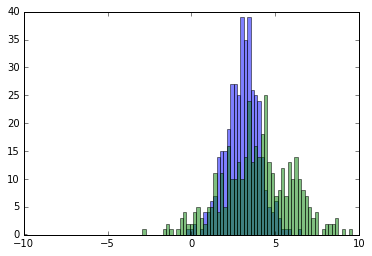

In [68]:
import random
histogram=plt.figure()
x=[
[random.gauss(3,1) for _ in range(400)]
,[random.gauss(4,2) for _ in range(400)]]

bins = np.linspace(-10, 10, 100)

plt.hist(x[0], bins, alpha=0.5)
plt.hist(x[1], bins, alpha=0.5)
plt.show()


In [4]:
import random
dc={0:'r',1:'b',2:'g'}
histogram=plt.figure()
x=[
[random.gauss(3,1) for _ in range(400)]
,[random.gauss(4,2) for _ in range(400)], [random.gauss(4,2) for _ in range(60)]]

bins = np.linspace(-10, 10, 100)
for i in range(3):
    plt.hist(x[i], bins, alpha=0.5)
#plt.hist(x[1], bins, alpha=0.5)
plt.show()


In [5]:
import random
histogram=plt.figure()
x=[
[random.gauss(3,1) for _ in range(400)]
,[random.gauss(4,2) for _ in range(400)], [random.gauss(4,2) for _ in range(60)]]

y=[
[random.gauss(3,1) for _ in range(400)]
,[random.gauss(4,2) for _ in range(400)], [random.gauss(4,2) for _ in range(60)]]



bins = np.linspace(-10, 10, 100)
for i in range(3):
    plt.scatter(x[i],y[i],color=dc[i])
#plt.hist(x[1], bins, alpha=0.5)
plt.show()


Nulls Feature-wise

In [21]:
TRAIN_DATE = 'C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Date\\train_1.gzip'
TRAIN_NUMERIC='C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Chunks\\Numeric\\train_1.gzip'

In [22]:
ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'
SEED = 0
CHUNKSIZE = 5000
NROWS = 25000

In [23]:
train = pd.read_csv(TRAIN_NUMERIC, usecols=[ID_COLUMN], nrows=NROWS,compression='gzip')

In [24]:
train["StartTime"] = -1

In [28]:

nrows = 0
for tr  in pd.read_csv(TRAIN_DATE, chunksize=CHUNKSIZE,compression='gzip') :
    feats = np.setdiff1d(tr.columns, [ID_COLUMN])
    print 'Feats: ',feats,'\n'
    stime_tr = tr[feats].min(axis=1).values
    #stime_te = te[feats].min(axis=1).values
    print stime_tr
    train.loc[train.Id.isin(tr.Id), 'StartTime'] = stime_tr
    #test.loc[test.Id.isin(te.Id), 'StartTime'] = stime_te

    nrows += CHUNKSIZE
    if nrows >= NROWS:
        break


ntrain = train.shape[0]


Feats:  ['L0_S0_D1' 'L0_S0_D11' 'L0_S0_D13' ..., 'L3_S51_D4259' 'L3_S51_D4261'
 'L3_S51_D4263'] 

[   82.24  1313.12  1618.7  ...,   979.96    99.69    99.69]
Feats:  ['L0_S0_D1' 'L0_S0_D11' 'L0_S0_D13' ..., 'L3_S51_D4259' 'L3_S51_D4261'
 'L3_S51_D4263'] 

[   99.69  1180.64  1412.04 ...,   640.6    808.83  1379.75]


In [32]:
train['diff']= train['Id'].diff()

In [39]:
train[['Id','diff']].head()

,Id,diff
0,4,NaN
1,6,2.0
2,7,1.0
3,9,2.0
4,11,2.0


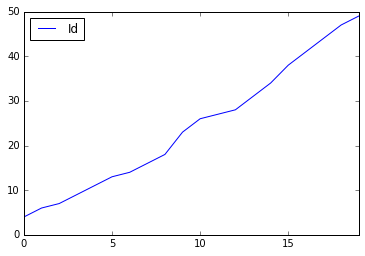

In [41]:
train[['Id']].head(20).plot()

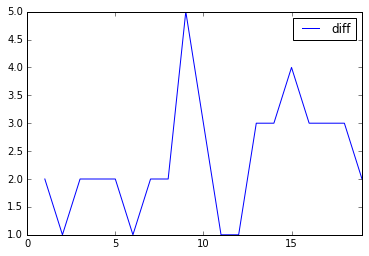

In [42]:
train[['diff']].head(20).plot()

In [44]:
np.setdiff1d(list(train.columns), [TARGET_COLUMN, ID_COLUMN]).tolist()


['StartTime', 'diff']

In [47]:
print train[ID_COLUMN].diff().fillna(9999999).astype(int)
print train[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)


0        9999999
1              2
2              1
3              2
4              2
5              2
6              1
7              2
8              2
9              5
10             3
11             1
12             1
13             3
14             3
15             4
16             3
17             3
18             3
19             2
20             3
21             3
22             1
23             1
24             6
25             5
26             2
27             1
28             1
29             1
          ...   
24970          1
24971          1
24972          1
24973          1
24974          1
24975          2
24976          3
24977          3
24978          5
24979          1
24980          1
24981          1
24982          2
24983          2
24984          2
24985          1
24986          3
24987          2
24988          1
24989          2
24990          2
24991          3
24992          3
24993          1
24994          2
24995          1
24996          2
24997         

In [66]:
train_date_part.shape

(20000, 1157)

# Sample




In [13]:
train_date = pd.read_csv('C:\\Users\\sushant\\Documents\\New Start\\Datasets\\Bosch\\Samples\\sample_date_bal6.csv',dtype=np.float32).set_index('Unnamed: 0')

time: 1.15 s


In [20]:
def corrlist(data):
    feat=data.columns.tolist()
    corrmat=np.array(data.corr())
    for i in range(len(corrmat)):
        for j in range(len(corrmat)):
            if j>i :
                corrmat[i][j]=2
    corrFrame= pd.DataFrame(pd.DataFrame(corrmat,columns=feat,index=feat).unstack()).reset_index()
    print plt.matshow(corrmat)
    del corrmat
    corrFrame=corrFrame[corrFrame[0]<=1].rename(columns={0:'corr'})
    return corrFrame

time: 7 ms


AxesImage(72,43.2;372x372)


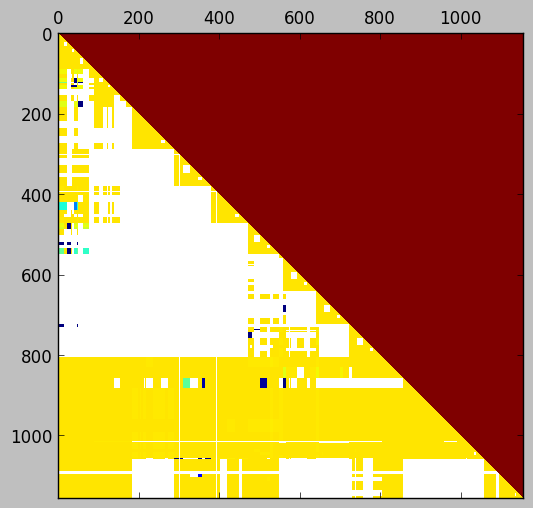

time: 24.6 s


In [31]:
sa = corrlist(train_date.drop('Id',1))

In [32]:
sa.sort('corr')

,level_0,level_1,corr
578737,L1_S25_D1965,L1_S25_D2788,-1.0
563709,L1_S25_D1902,L1_S25_D2788,-1.0
574113,L1_S25_D1945,L1_S25_D2788,-1.0
579893,L1_S25_D1970,L1_S25_D2788,-1.0
564865,L1_S25_D1906,L1_S25_D2788,-1.0
572957,L1_S25_D1940,L1_S25_D2788,-1.0
566021,L1_S25_D1911,L1_S25_D2788,-1.0
577581,L1_S25_D1960,L1_S25_D2788,-1.0
569489,L1_S25_D1926,L1_S25_D2788,-1.0
571801,L1_S25_D1935,L1_S25_D2788,-1.0


time: 84 ms


In [35]:
sa['LineNo0']=sa['level_0'].apply(lambda l: l.split('_')[0])
sa['StationNo0']=sa['level_0'].apply(lambda l: l.split('_')[1])
sa['FeatureNo0']=sa['level_0'].apply(lambda l: l.split('_')[2])
sa['LineNo1']=sa['level_1'].apply(lambda l: l.split('_')[0])
sa['StationNo1']=sa['level_1'].apply(lambda l: l.split('_')[1])
sa['FeatureNo1']=sa['level_1'].apply(lambda l: l.split('_')[2])

time: 1.09 s


In [46]:
sa[sa['corr']==1][['FeatureNo1','FeatureNo0']].drop_duplicates().to_csv('Date_corr.csv')#.set_index('FeatureNo0')

time: 323 ms


time: 9 ms


In [53]:
#x=set(corr1['level_1'].tolist())
#y=set(corr1['level_0'].tolist())


{'L1_S25_D2424',
 'L1_S25_D2427',
 'L3_S43_D4062',
 'L1_S25_D2348',
 'L3_S43_D4067',
 'L1_S25_D2839',
 'L1_S25_D2834',
 'L3_S30_D3531',
 'L1_S25_D2830',
 'L1_S25_D2343',
 'L3_S29_D3492',
 'L1_S25_D2982',
 'L1_S25_D2421',
 'L3_S50_D4246',
 'L3_S50_D4242',
 'L1_S24_D1619',
 'L0_S3_D102',
 'L1_S24_D1755',
 'L1_S25_D2507',
 'L1_S25_D2780',
 'L1_S24_D1611',
 'L3_S47_D4175',
 'L1_S24_D1615',
 'L1_S25_D2338',
 'L1_S25_D1926',
 'L1_S25_D1921',
 'L1_S25_D2883',
 'L3_S37_D3943',
 'L1_S25_D2333',
 'L1_S24_D1408',
 'L3_S30_D3536',
 'L3_S30_D3546',
 'L3_S30_D3776',
 'L1_S24_D841',
 'L1_S25_D2151',
 'L1_S24_D846',
 'L1_S24_D1837',
 'L1_S24_D1209',
 'L1_S25_D2501',
 'L3_S37_D3947',
 'L1_S25_D2908',
 'L3_S29_D3405',
 'L3_S29_D3402',
 'L2_S28_D3296',
 'L1_S25_D2903',
 'L3_S36_D3928',
 'L3_S39_D3966',
 'L3_S33_D3856',
 'L3_S29_D3408',
 'L1_S24_D1833',
 'L2_S27_D3203',
 'L2_S27_D3200',
 'L2_S27_D3207',
 'L3_S35_D3915',
 'L1_S25_D2058',
 'L1_S24_D693',
 'L1_S24_D689',
 'L0_S15_D416',
 'L1_S24_D894',
 'L0_

time: 48 ms


In [51]:
corr1['lev3']=corr1['level_1'].apply(lambda l:int(l)) - corr1['level_0'].apply(lambda l:int(l))

ValueError: invalid literal for int() with base 10: 'L0_S0_D1'

time: 52 ms


In [45]:
corr1['lev3'].apply(lambda x: x)

1              L0_S0_D1|Id
2              L0_S0_D3|Id
3              L0_S0_D5|Id
4              L0_S0_D7|Id
5              L0_S0_D9|Id
6             L0_S0_D11|Id
7             L0_S0_D13|Id
8             L0_S0_D15|Id
9             L0_S0_D17|Id
10            L0_S0_D19|Id
11            L0_S0_D21|Id
12            L0_S0_D23|Id
13            L0_S1_D26|Id
14            L0_S1_D30|Id
15            L0_S2_D34|Id
16            L0_S2_D38|Id
17            L0_S2_D42|Id
18            L0_S2_D46|Id
19            L0_S2_D50|Id
20            L0_S2_D54|Id
21            L0_S2_D58|Id
22            L0_S2_D62|Id
23            L0_S2_D66|Id
24            L0_S3_D70|Id
25            L0_S3_D74|Id
26            L0_S3_D78|Id
27            L0_S3_D82|Id
28            L0_S3_D86|Id
29            L0_S3_D90|Id
30            L0_S3_D94|Id
                ...       
1303939    Id|L3_S47_D4175
1305096    Id|L3_S47_D4180
1306253    Id|L3_S47_D4185
1307410    Id|L3_S47_D4190
1308567    Id|L3_S48_D4194
1309724    Id|L3_S48_D4195
1

time: 16 ms


In [54]:
corr1.to_csv('listcorr.csv')

time: 61 ms


In [5]:
train_date.min(axis=1)

Unnamed: 0
172.0      351.000000
566.0     1113.000000
601.0     1186.000000
681.0      640.200012
887.0     1153.459961
1152.0     961.650024
1208.0     553.909973
1237.0     807.840027
1316.0    1625.800049
1679.0    1214.380005
1748.0    1647.239990
1967.0     668.270020
2028.0     200.619995
2077.0    1105.780029
2469.0     680.650024
2489.0     712.630005
2490.0     712.630005
2572.0     612.450012
2922.0     303.489990
2931.0    1410.400024
2952.0     922.200012
2974.0     773.179993
3344.0    1356.790039
3400.0     248.570007
3449.0    1210.839966
3726.0     408.630005
3897.0    1142.689941
3927.0     958.729980
4027.0     943.159973
4208.0     257.399994
             ...     
8461.0     224.149994
8717.0     535.690002
9118.0      90.779999
9445.0     662.619995
9517.0     906.559998
9527.0     204.949997
9545.0     222.300003
9600.0    1412.010010
9603.0    1411.780029
9611.0     824.349976
9666.0    1378.380005
336.0     1331.130005
462.0     1373.449951
867.0      566.340027

time: 291 ms


In [6]:
train_date['minDate']=train_date.min(axis=1)
train_date['maxDate']=train_date.max(axis=1)

time: 570 ms


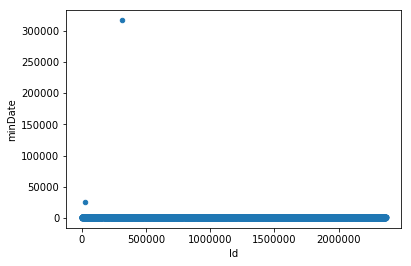

time: 516 ms


In [7]:
train_date[['Id','minDate']].set_index('Id').sort().reset_index().plot('Id','minDate',kind='scatter')#.to_csv('IdMin.csv',index=False)#.plot()

In [8]:
train_date.drop_duplicates().info(),train_date.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 9030 entries, 172.0 to 3722.0
Columns: 1159 entries, Id to maxDate
dtypes: float32(1159)
memory usage: 40.0 MB
<class 'pandas.core.frame.DataFrame'>
Float64Index: 9030 entries, 172.0 to 3722.0
Columns: 1159 entries, Id to maxDate
dtypes: float32(1159)
memory usage: 40.0 MB


(None, None)

time: 647 ms


In [9]:
idc=train_date.head(10)['Id'].tolist()

time: 2 ms


In [10]:
train_date.head(10).dropna(axis=1)

,Id,minDate,maxDate
Unnamed: 0,,,
172.0,351.0,351.000000,610.750000
566.0,1113.0,1113.000000,1205.390015
601.0,1186.0,1186.000000,1467.420044
681.0,1350.0,640.200012,1350.000000
887.0,1793.0,1153.459961,1793.000000
1152.0,2347.0,961.650024,2347.000000
1208.0,2452.0,553.909973,2452.000000
1237.0,2510.0,807.840027,2510.000000
1316.0,2666.0,1625.800049,2666.000000


time: 15 ms


In [11]:
ttpose=train_date.set_index('Id').transpose()#.reset_index()

time: 48 ms


In [ ]:
ttpose.corr().to_csv('DateCorr.csv')

In [ ]:
ttpose=ttpose[ttpose['index']!='Id'].fillna(0)

ttpose['LineNo']=ttpose['index'].apply(lambda l: l.split('_')[0])
ttpose['StationNo']=ttpose['index'].apply(lambda l: l.split('_')[1])
ttpose['FeatureNo']=ttpose['index'].apply(lambda l: l.split('_')[2])

In [ ]:
ttpose

In [124]:
lst=idc+['LineNo','StationNo']
lst

[351.0,
 1113.0,
 1186.0,
 1350.0,
 1793.0,
 2347.0,
 2452.0,
 2510.0,
 2666.0,
 3411.0,
 'LineNo',
 'StationNo']

time: 5 ms


Unnamed: 0,index,172.0,566.0,601.0,681.0,887.0,1152.0,1208.0,1237.0,1316.0,1679.0,LineNo,StationNo,FeatureNo
1,L0_S0_D1,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D1
2,L0_S0_D3,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D3
3,L0_S0_D5,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D5
4,L0_S0_D7,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D7
5,L0_S0_D9,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D9
6,L0_S0_D11,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D11
7,L0_S0_D13,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D13
8,L0_S0_D15,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D15
9,L0_S0_D17,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D17
10,L0_S0_D19,608.830017,0.0,1465.189941,640.200012,1153.459961,961.650024,0.0,0.0,1625.800049,1214.380005,L0,S0,D19


time: 134 ms


In [131]:
nodup=ttpose.drop(['index','FeatureNo'],1).drop_duplicates()

time: 6 ms


In [135]:
nodup

Unnamed: 0,172.0,566.0,601.0,681.0,887.0,1152.0,1208.0,1237.0,1316.0,1679.0,LineNo,StationNo
1,608.830017,0.000000,1465.189941,640.200012,1153.459961,961.650024,0.000000,0.000000,1625.800049,1214.380005,L0,S0
13,608.830017,0.000000,1465.189941,640.200012,1153.459961,961.650024,0.000000,0.000000,1625.800049,1214.380005,L0,S1
15,0.000000,0.000000,0.000000,640.210022,0.000000,0.000000,0.000000,0.000000,1625.810059,0.000000,L0,S2
24,608.840027,0.000000,1465.189941,0.000000,1153.469971,961.650024,0.000000,0.000000,0.000000,1214.380005,L0,S3
33,0.000000,0.000000,0.000000,640.219971,0.000000,0.000000,0.000000,0.000000,1625.819946,0.000000,L0,S4
35,608.849976,0.000000,1465.199951,0.000000,1153.500000,961.679993,0.000000,0.000000,0.000000,1214.400024,L0,S5
37,0.000000,0.000000,0.000000,0.000000,1153.500000,0.000000,0.000000,0.000000,1625.819946,0.000000,L0,S6
42,608.849976,0.000000,1465.209961,640.219971,0.000000,961.679993,0.000000,0.000000,0.000000,1214.410034,L0,S7
47,608.849976,0.000000,1465.209961,640.229980,1153.500000,961.679993,0.000000,0.000000,1625.819946,1214.410034,L0,S8
51,608.859985,0.000000,1465.209961,0.000000,1153.500000,961.690002,0.000000,0.000000,1625.829956,0.000000,L0,S9


time: 129 ms
